In [101]:
import os
import boto3
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats

In [104]:
session = boto3.session.Session(profile_name='homeusr')
s3 = session.resource('s3')

alpha_samples = pickle.loads(s3.Bucket("bayesian-baseball").Object("20200913/alpha_samples.pkl").get()['Body'].read())
beta_samples = pickle.loads(s3.Bucket("bayesian-baseball").Object("20200913/beta_samples.pkl").get()['Body'].read())
gamma_samples = pickle.loads(s3.Bucket("bayesian-baseball").Object("20200913/gamma_samples.pkl").get()['Body'].read())
elite_samples = pickle.loads(s3.Bucket("bayesian-baseball").Object("20200913/elite_samples.pkl").get()['Body'].read())
nu_samples = pickle.loads(s3.Bucket("bayesian-baseball").Object("20200913/nu_samples.pkl").get()['Body'].read())

In [105]:
data = pd.read_csv('../data/processed/test_data.csv').reset_index(drop=True)
# data.rename(columns={'park_clean':'park'}, inplace=True)

data['position_main'] = data['position_main'] - 1 

data.drop(columns=['birthYear', 'debut'], inplace=True)

POSITION_DICT = {0: 'C', 1: '1B', 2: '2B', 3: '3B', 4: 'SS', 5: 'LF', 6: 'CF', 7: 'RF', 8: 'DH'}

In [106]:
data_e = data.assign(elite_status=elite_samples)
data_e[data_e['elite_status'] == 1]

,playerID,yearID,team,AB,HR,position_main,park,playerAge,yearsInMLB,playerFullName,elite_status
1,casteni01,2014,DET,533,11,3,Comerica Park,22,2,Nick Castellanos,1
16,cruzne02,2008,TEX,115,7,7,Rangers Ballpark in Arlington,28,4,Nelson Cruz,1
18,cruzne02,2010,TEX,399,22,7,Rangers Ballpark in Arlington,30,6,Nelson Cruz,1
21,cruzne02,2013,TEX,413,27,7,Rangers Ballpark in Arlington,33,9,Nelson Cruz,1
30,gerbemi01,2018,DET,42,0,5,Comerica Park,26,1,Mike Gerber,1
41,guzmaro01,2018,TEX,387,16,1,Rangers Ballpark in Arlington,24,1,Ronald Guzman,1
49,johnsbe02,2006,SDN,120,4,5,Petco Park,25,2,Ben Johnson,1
53,machama01,2014,BAL,327,12,3,Oriole Park at Camden Yards,22,3,Manny Machado,1
61,mohrdu01,2002,MIN,383,12,7,Hubert H Humphrey Metrodome,26,2,Dustan Mohr,1
65,mohrdu01,2006,BOS,40,2,6,Fenway Park II,30,6,Dustan Mohr,1


In [107]:
data_e[data_e['playerID'] == 'troutmi01']

,playerID,yearID,team,AB,HR,position_main,park,playerAge,yearsInMLB,playerFullName,elite_status
86,troutmi01,2011,LAA,123,5,6,Angel Stadium,20,1,Mike Trout,1
87,troutmi01,2012,LAA,559,30,6,Angel Stadium of Anaheim,21,2,Mike Trout,0
88,troutmi01,2013,LAA,589,27,6,Angel Stadium of Anaheim,22,3,Mike Trout,0
89,troutmi01,2014,LAA,602,36,6,Angel Stadium of Anaheim,23,4,Mike Trout,0
90,troutmi01,2015,LAA,575,41,6,Angel Stadium of Anaheim,24,5,Mike Trout,0
91,troutmi01,2016,LAA,549,29,6,Angel Stadium of Anaheim,25,6,Mike Trout,0
92,troutmi01,2017,LAA,402,33,6,Angel Stadium of Anaheim,26,7,Mike Trout,0
93,troutmi01,2018,LAA,471,39,6,Angel Stadium of Anaheim,27,8,Mike Trout,0


In [108]:
-np.log((1/.05) - 1)

-2.9444389791664403

In [100]:
theta(0, 0, 0)

0.5

In [109]:
def theta(alpha, beta, age_trajectory_val):
    inner = alpha + beta + age_trajectory_val
    if inner > 100:
        return 1 - 1e-16
    if inner < -100:
        return 1e-16
    return 1 / (1 + np.exp(-inner))

def age_trajectory(age, gamma):
    """ Put docstring here """
    return gamma[0] + age * gamma[1] + (age ** 2) * gamma[2] + (age ** 3) * gamma[3]

In [110]:
def age_trajectory(age, gamma):
    '''Fit piecewise linear function'''
    if age > 28:
        return gamma[2] + gamma[3] * age
    else: 
        return gamma[0] + gamma[1] * age

In [124]:
alpha_burn = alpha_samples[0] # alpha_samples[0][1500:]
beta_burn = beta_samples[0] # beta_samples[0][1500:]
gamma_burn = gamma_samples[0] # gamma_samples[0][1500:]

In [112]:
alpha_burn[0][6, 0]

IndexError: list index out of range

In [121]:
trout = data_e[data_e['playerID'] == 'troutmi01']

In [116]:
parks = sorted(data.park.unique())

In [136]:
parks = sorted(data.park.unique())
thetas = []
for _, row in trout.iterrows():
    for i in range(len(alpha_burn)):
        park_idx = parks.index(row['park'])
        age_traj = age_trajectory(row['playerAge'], gamma_burn[i][row['position_main']])
        theta_ = theta(alpha_burn[i][row['position_main'], row['elite_status']],
                       beta_burn[i][park_idx],
                       age_traj)
        thetas.append(theta_)

In [128]:
len(alpha_burn)

51

In [140]:
gamma_burn

[array([[ 2.40240191,  1.03928289,  1.71651649,  2.03282155],
        [ 0.98702023,  0.32168802,  1.44166737,  0.9151481 ],
        [ 0.86813701,  1.85627986,  0.36099738,  0.72048887],
        [-0.65191074,  1.02882751,  0.45069559,  1.14873288],
        [ 1.75647052,  2.49111993,  1.98194349, -0.34773398],
        [ 0.22043492, -0.09199764,  1.04317279,  0.70737828],
        [ 0.61287182,  1.11162936,  0.221557  ,  0.85418585],
        [-0.58613255,  1.80876796,  2.23065967,  1.47912469],
        [ 1.80959905,  0.73269086, -0.63703074,  1.05447502]]),
 array([[ 1.35706618,  0.99416558,  3.40495956,  3.64373927],
        [ 1.48680897, -0.87329383, -0.02446082, -0.57948397],
        [ 0.91193739,  2.0771131 ,  1.00548754,  0.53727566],
        [-1.47212244, -0.57287243,  0.37897086,  0.11123663],
        [ 3.22906371,  1.57510745,  1.76445707,  0.81109023],
        [ 0.48680881, -2.1970723 ,  1.23058014,  0.66177044],
        [-0.2650783 ,  1.12730773,  1.62713531, -0.45854925],
      

In [137]:
thetas

[0.9999999999063276,
 0.9999999998352898,
 0.9999999999989746,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999989406956,
 0.9999999981663343,
 0.9999999999917109,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.999999999651465,
 0.9999999994060682,
 0.9999999999980504,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1

In [67]:
trout['hr_rate'] = trout['HR'] / trout['AB']

<ipython-input-67-fa85643f0faa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trout['hr_rate'] = trout['HR'] / trout['AB']


In [68]:
trout

,playerID,yearID,team,AB,HR,position_main,park,playerAge,yearsInMLB,playerFullName,elite_status,hr_rate
86,troutmi01,2011,LAA,123,5,6,Angel Stadium,20,1,Mike Trout,0,0.040650
87,troutmi01,2012,LAA,559,30,6,Angel Stadium of Anaheim,21,2,Mike Trout,0,0.053667
88,troutmi01,2013,LAA,589,27,6,Angel Stadium of Anaheim,22,3,Mike Trout,0,0.045840
89,troutmi01,2014,LAA,602,36,6,Angel Stadium of Anaheim,23,4,Mike Trout,0,0.059801
90,troutmi01,2015,LAA,575,41,6,Angel Stadium of Anaheim,24,5,Mike Trout,0,0.071304
91,troutmi01,2016,LAA,549,29,6,Angel Stadium of Anaheim,25,6,Mike Trout,0,0.052823
92,troutmi01,2017,LAA,402,33,6,Angel Stadium of Anaheim,26,7,Mike Trout,0,0.082090
93,troutmi01,2018,LAA,471,39,6,Angel Stadium of Anaheim,27,8,Mike Trout,0,0.082803


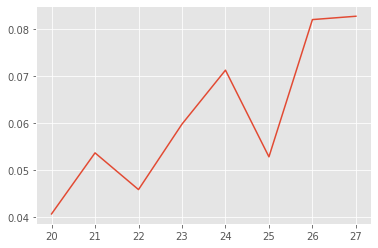

In [69]:
plt.style.use('ggplot')

plt.plot(trout['playerAge'], trout['hr_rate'])
plt.show()